In [ ]:
# !pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 35.6 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import keras_cv
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sn
import matplotlib.pyplot as plt

keras.utils.set_random_seed(31)

### Create the Model

In [3]:
def residual_block(x, filters:int, kernel_size:int=3, stride:int=1, conv_shortcut:bool=True):
    shortcut = x

    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # First convolution
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second convolution
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Add shortcut
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)

    return x

In [4]:
def build_resnet(input_shape:tuple=(32, 32, 3), num_classes:int=10) -> tf.keras.Model:
    inputs = layers.Input(shape=input_shape)

    # initial convolution
    x = layers.Conv2D(64, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 64 filter blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64, conv_shortcut=False)
    x = residual_block(x, 64, conv_shortcut=False)

    # 128 filter blocks
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, conv_shortcut=False)
    x = residual_block(x, 128, conv_shortcut=False)
    x = residual_block(x, 128, conv_shortcut=False)

    # 256 filter blocks
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, conv_shortcut=False)
    x = residual_block(x, 256, conv_shortcut=False)
    x = residual_block(x, 256, conv_shortcut=False)
    x = residual_block(x, 256, conv_shortcut=False)
    x = residual_block(x, 256, conv_shortcut=False)

    # 512 filter blocks
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512, conv_shortcut=False)
    x = residual_block(x, 512, conv_shortcut=False)

    # glob. avg. pool and final output
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

### Prepare the Data

In [5]:
classes = ["airplane",
          "automobile",
          "bird",
          "cat",
          "deer",
          "dog",
          "frog",
          "horse",
          "ship",
          "truck"]

In [6]:
def prepare_dataset(dataset, shuffle:bool=True, augment:bool=False):

    rand_augment = keras_cv.layers.RandAugment(
      value_range=(0, 255), augmentations_per_image=3, magnitude=0.2
    )

    if shuffle:
      dataset = dataset.shuffle(BATCH_SIZE * 1000)

    dataset = dataset.batch(BATCH_SIZE)

    dataset = dataset.map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: (rand_augment(x), y),  # RandAugment can process it
            num_parallel_calls=AUTO,
        )

    dataset = dataset.map(
        lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
        num_parallel_calls=AUTO,
    )

    return dataset.prefetch(AUTO)

In [7]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = 32

In [25]:
def fetch_and_augment_cifar10() -> tuple:
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

    # partition the train data to obtain a val data
    num_samples = x_train.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices, )     # shuffle to avoid bias

    x_train, y_train = x_train[indices], y_train[indices]

    val_size = int(0.1 * num_samples)

    # 45000 train and 5000 val datapoints
    x_val, y_val = x_train[:val_size], y_train[:val_size]
    x_train, y_train = x_train[val_size:], y_train[val_size:]


    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    test_ds = tf.data.Dataset.from_tensor_slices((x_test,  y_test))

    train_ds_original = prepare_dataset(train_ds)
    train_ds = prepare_dataset(train_ds, shuffle=True, augment=True)
    val_ds = prepare_dataset(val_ds)
    test_ds = prepare_dataset(test_ds, shuffle=False)

    return (train_ds, val_ds, test_ds, train_ds_original)

In [26]:
train_ds, val_ds, test_ds, train_ds_original = fetch_and_augment_cifar10()

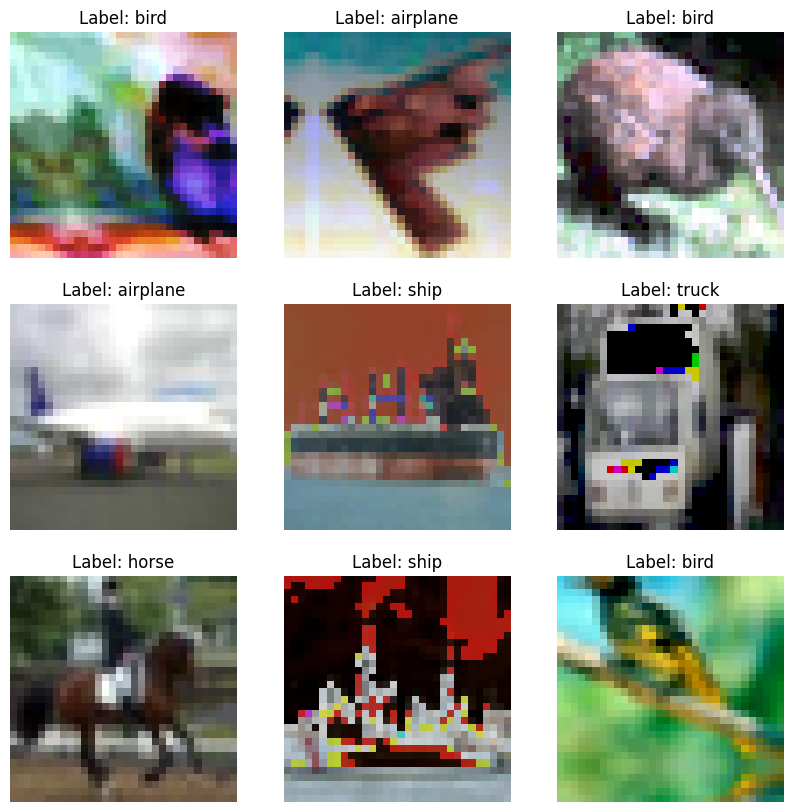

In [10]:
sample_images, labels = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(f"Label: {classes[int(labels[i])]}")
    plt.axis("off")

### Train the Model

In [11]:
def train_resnet(train_ds:tf.data.Dataset, val_ds:tf.data.Dataset) -> tuple:
    # build model
    model = build_resnet()

    # compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'resnet_cifar10.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    callbacks = [
        early_stopping,
        lr_scheduler,
        model_checkpoint
    ]

    # train the model
    history = model.fit(
        train_ds,
        epochs=150,
        validation_data=val_ds,
        callbacks=callbacks
    )

    return model, history

In [12]:
model, history = train_resnet(train_ds, val_ds)

Epoch 1/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2472 - loss: 2.1870
Epoch 1: val_accuracy improved from -inf to 0.40660, saving model to resnet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 119s 55ms/step - accuracy: 0.2472 - loss: 2.1868 - val_accuracy: 0.4066 - val_loss: 1.6148 - learning_rate: 0.0010
Epoch 2/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4638 - loss: 1.5002
Epoch 2: val_accuracy improved from 0.40660 to 0.55020, saving model to resnet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 61s 42ms/step - accuracy: 0.4639 - loss: 1.5001 - val_accuracy: 0.5502 - val_loss: 1.4204 - learning_rate: 0.0010
Epoch 3/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5728 - loss: 1.2137
Epoch 3: val_accuracy improved from 0.55020 to 0.61960, saving model to resnet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 60s 42ms/step - accuracy: 0.5729 - loss: 1.2136 - val_accuracy: 0.6196 - val_loss: 1.0350 - learning_rate: 0.0010
Epoch 4/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6267 - loss: 1.0578
Epoch 4: val_accuracy improved from 0.61960 to 0.66800, saving model to resnet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 60s 42ms/step - accuracy: 0.6267 - loss: 1.0577 - val_accuracy: 0.6680 - val_loss: 0.9791 - learning_rate: 0.0010
Epoch 5/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6706 - loss: 0.9331
Epoch 5: val_accuracy improved from 0.66800 to 0.78540, saving model to resnet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 60s 41ms/step - accuracy: 0.6706 - loss: 0.9331 - val_accuracy: 0.7854 - val_loss: 0.6266 - learning_rate: 0.0010
Epoch 6/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7101 - loss: 0.8257
Epoch 6: val_accuracy improved from 0.78540 to 0.81020, saving model to resnet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 60s 41ms/step - accuracy: 0.7101 - loss: 0.8257 - val_accuracy: 0.8102 - val_loss: 0.5600 - learning_rate: 0.0010
Epoch 7/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7452 - loss: 0.7285
Epoch 7: val_accuracy did not improve from 0.81020
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 41ms/step - accuracy: 0.7452 - loss: 0.7285 - val_accuracy: 0.7896 - val_loss: 0.6042 - learning_rate: 0.0010
Epoch 8/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7669 - loss: 0.6720
Epoch 8: val_accuracy did not improve from 0.81020
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 41ms/step - accuracy: 0.7669 - loss: 0.6720 - val_accuracy: 0.8088 - val_loss: 0.5581 - learning_rate: 0.0010
Epoch 9/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7931 - loss: 0.6120
Epoch 9: val_accuracy improved from 0.81020 to 0.82580, saving model to resnet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 61s 42ms/step - accuracy: 0.7931 - loss: 0.6120 - val_accuracy: 0.8258 - val_loss: 0.4968 - learning_rate: 0.0010
Epoch 10/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8068 - loss: 0.5662
Epoch 10: val_accuracy improved from 0.82580 to 0.86560, saving model to resnet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 62s 43ms/step - accuracy: 0.8068 - loss: 0.5663 - val_accuracy: 0.8656 - val_loss: 0.3870 - learning_rate: 0.0010
Epoch 11/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8190 - loss: 0.5236
Epoch 11: val_accuracy did not improve from 0.86560
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 60s 42ms/step - accuracy: 0.8190 - loss: 0.5236 - val_accuracy: 0.8620 - val_loss: 0.4112 - learning_rate: 0.0010
Epoch 12/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8253 - loss: 0.5015
Epoch 12: val_accuracy did not improve from 0.86560
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 41ms/step - accuracy: 0.8253 - loss: 0.5014 - val_accuracy: 0.8578 - val_loss: 0.4132 - learning_rate: 0.0010
Epoch 13/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8395 - loss: 0.4616
Epoch 13: val_accuracy did not improve from 0.86560
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 61s 42ms/step - accuracy: 0.8395 - loss: 0.4616 - val_accuracy: 0.8208 - val_loss: 0.5645 - learning_rate

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 60s 41ms/step - accuracy: 0.8612 - loss: 0.4115 - val_accuracy: 0.8700 - val_loss: 0.3743 - learning_rate: 0.0010
Epoch 16/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8671 - loss: 0.3809
Epoch 16: val_accuracy improved from 0.87000 to 0.88780, saving model to resnet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 60s 41ms/step - accuracy: 0.8671 - loss: 0.3809 - val_accuracy: 0.8878 - val_loss: 0.3241 - learning_rate: 0.0010
Epoch 17/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8775 - loss: 0.3610
Epoch 17: val_accuracy did not improve from 0.88780
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 60s 41ms/step - accuracy: 0.8775 - loss: 0.3610 - val_accuracy: 0.8820 - val_loss: 0.3480 - learning_rate: 0.0010
Epoch 18/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8805 - loss: 0.3449
Epoch 18: val_accuracy did not improve from 0.88780
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 60s 41ms/step - accuracy: 0.8805 - loss: 0.3449 - val_accuracy: 0.8788 - val_loss: 0.3696 - learning_rate: 0.0010
Epoch 19/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8861 - loss: 0.3335
Epoch 19: val_accuracy did not improve from 0.88780
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 41ms/step - accuracy: 0.8861 - loss: 0.3335 - val_accuracy: 0.8724 - val_loss: 0.3964 - learning_rate

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 41ms/step - accuracy: 0.8937 - loss: 0.3093 - val_accuracy: 0.8962 - val_loss: 0.3104 - learning_rate: 0.0010
Epoch 21/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8993 - loss: 0.2895
Epoch 21: val_accuracy did not improve from 0.89620
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 40ms/step - accuracy: 0.8993 - loss: 0.2895 - val_accuracy: 0.8944 - val_loss: 0.3189 - learning_rate: 0.0010
Epoch 22/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9069 - loss: 0.2752
Epoch 22: val_accuracy did not improve from 0.89620
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 41ms/step - accuracy: 0.9069 - loss: 0.2752 - val_accuracy: 0.8920 - val_loss: 0.3666 - learning_rate: 0.0010
Epoch 23/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9065 - loss: 0.2724
Epoch 23: val_accuracy improved from 0.89620 to 0.89960, saving model to resnet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 61s 42ms/step - accuracy: 0.9065 - loss: 0.2724 - val_accuracy: 0.8996 - val_loss: 0.3105 - learning_rate: 0.0010
Epoch 24/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9136 - loss: 0.2521
Epoch 24: val_accuracy did not improve from 0.89960
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 41ms/step - accuracy: 0.9136 - loss: 0.2522 - val_accuracy: 0.8890 - val_loss: 0.3370 - learning_rate: 0.0010
Epoch 25/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9132 - loss: 0.2492
Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 25: val_accuracy did not improve from 0.89960
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 40ms/step - accuracy: 0.9132 - loss: 0.2492 - val_accuracy: 0.8992 - val_loss: 0.3283 - learning_rate: 0.0010
Epoch 26/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9319 - loss: 0.1958
Epoch 26: val_accuracy improved from 0.89960 to 0.92160, saving model to resnet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 60s 41ms/step - accuracy: 0.9319 - loss: 0.1958 - val_accuracy: 0.9216 - val_loss: 0.2576 - learning_rate: 5.0000e-04
Epoch 27/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9430 - loss: 0.1695
Epoch 27: val_accuracy did not improve from 0.92160
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 41ms/step - accuracy: 0.9430 - loss: 0.1695 - val_accuracy: 0.9122 - val_loss: 0.2696 - learning_rate: 5.0000e-04
Epoch 28/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9433 - loss: 0.1672
Epoch 28: val_accuracy did not improve from 0.92160
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 40ms/step - accuracy: 0.9433 - loss: 0.1672 - val_accuracy: 0.9184 - val_loss: 0.2671 - learning_rate: 5.0000e-04
Epoch 29/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9453 - loss: 0.1594
Epoch 29: val_accuracy did not improve from 0.92160
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 60s 41ms/step - accuracy: 0.9453 - loss: 0.1594 - val_accuracy: 0.9088 - val_loss: 0.2959 - l

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 60s 41ms/step - accuracy: 0.9550 - loss: 0.1312 - val_accuracy: 0.9236 - val_loss: 0.2539 - learning_rate: 2.5000e-04
Epoch 33/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9621 - loss: 0.1125
Epoch 33: val_accuracy did not improve from 0.92360
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 41ms/step - accuracy: 0.9621 - loss: 0.1125 - val_accuracy: 0.9228 - val_loss: 0.2604 - learning_rate: 2.5000e-04
Epoch 34/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9631 - loss: 0.1084
Epoch 34: val_accuracy improved from 0.92360 to 0.92780, saving model to resnet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 62s 43ms/step - accuracy: 0.9631 - loss: 0.1084 - val_accuracy: 0.9278 - val_loss: 0.2523 - learning_rate: 2.5000e-04
Epoch 35/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9630 - loss: 0.1070
Epoch 35: val_accuracy did not improve from 0.92780
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 61s 42ms/step - accuracy: 0.9630 - loss: 0.1070 - val_accuracy: 0.9238 - val_loss: 0.2684 - learning_rate: 2.5000e-04
Epoch 36/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9659 - loss: 0.1042
Epoch 36: val_accuracy did not improve from 0.92780
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 60s 41ms/step - accuracy: 0.9659 - loss: 0.1042 - val_accuracy: 0.9276 - val_loss: 0.2564 - learning_rate: 2.5000e-04
Epoch 37/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9642 - loss: 0.1045
Epoch 37: val_accuracy did not improve from 0.92780
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 41ms/step - accuracy: 0.9642 - loss: 0.1045 - val_accuracy: 0.9262 - val_loss: 0.2494 - l

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 63s 44ms/step - accuracy: 0.9725 - loss: 0.0789 - val_accuracy: 0.9316 - val_loss: 0.2533 - learning_rate: 1.2500e-04
Epoch 46/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9732 - loss: 0.0808
Epoch 46: val_accuracy did not improve from 0.93160
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 60s 41ms/step - accuracy: 0.9732 - loss: 0.0808 - val_accuracy: 0.9264 - val_loss: 0.2603 - learning_rate: 1.2500e-04
Epoch 47/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9735 - loss: 0.0795
Epoch 47: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 47: val_accuracy did not improve from 0.93160
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 41ms/step - accuracy: 0.9735 - loss: 0.0795 - val_accuracy: 0.9298 - val_loss: 0.2543 - learning_rate: 1.2500e-04
Epoch 48/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9759 - loss: 0.0722
Epoch 48: val_accuracy improved from 0.93160 to 0.93200, saving model to resnet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 60s 42ms/step - accuracy: 0.9759 - loss: 0.0722 - val_accuracy: 0.9320 - val_loss: 0.2494 - learning_rate: 6.2500e-05
Epoch 49/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9747 - loss: 0.0762
Epoch 49: val_accuracy did not improve from 0.93200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 41ms/step - accuracy: 0.9747 - loss: 0.0762 - val_accuracy: 0.9312 - val_loss: 0.2526 - learning_rate: 6.2500e-05
Epoch 50/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9780 - loss: 0.0660
Epoch 50: val_accuracy improved from 0.93200 to 0.93220, saving model to resnet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 61s 42ms/step - accuracy: 0.9780 - loss: 0.0660 - val_accuracy: 0.9322 - val_loss: 0.2425 - learning_rate: 6.2500e-05
Epoch 51/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9788 - loss: 0.0654
Epoch 51: val_accuracy did not improve from 0.93220
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 41ms/step - accuracy: 0.9788 - loss: 0.0654 - val_accuracy: 0.9320 - val_loss: 0.2442 - learning_rate: 6.2500e-05
Epoch 52/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9781 - loss: 0.0671
Epoch 52: val_accuracy did not improve from 0.93220
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 41ms/step - accuracy: 0.9781 - loss: 0.0671 - val_accuracy: 0.9306 - val_loss: 0.2472 - learning_rate: 6.2500e-05
Epoch 53/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9771 - loss: 0.0666
Epoch 53: val_accuracy improved from 0.93220 to 0.93360, saving model to resnet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 60s 42ms/step - accuracy: 0.9771 - loss: 0.0666 - val_accuracy: 0.9336 - val_loss: 0.2388 - learning_rate: 6.2500e-05
Epoch 54/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9780 - loss: 0.0646
Epoch 54: val_accuracy improved from 0.93360 to 0.93500, saving model to resnet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 60s 41ms/step - accuracy: 0.9780 - loss: 0.0646 - val_accuracy: 0.9350 - val_loss: 0.2501 - learning_rate: 6.2500e-05
Epoch 55/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9798 - loss: 0.0643
Epoch 55: val_accuracy did not improve from 0.93500
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 60s 41ms/step - accuracy: 0.9798 - loss: 0.0643 - val_accuracy: 0.9328 - val_loss: 0.2473 - learning_rate: 6.2500e-05
Epoch 56/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9788 - loss: 0.0616
Epoch 56: val_accuracy did not improve from 0.93500
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 61s 42ms/step - accuracy: 0.9788 - loss: 0.0616 - val_accuracy: 0.9332 - val_loss: 0.2427 - learning_rate: 6.2500e-05
Epoch 57/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9777 - loss: 0.0680
Epoch 57: val_accuracy did not improve from 0.93500
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 41ms/step - accuracy: 0.9777 - loss: 0.0680 - val_accuracy: 0.9318 - val_loss: 0.2482 - l

### Evaluate the Model

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │          4,160 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)    

 Total params: 63,901,920 (243.77 MB)

 Trainable params: 21,294,922 (81.23 MB)

 Non-trainable params: 17,152 (67.00 KB)

 Optimizer params: 42,589,846 (162.47 MB)

In [13]:
_, acc = model.evaluate(train_ds_original)
print("Original Training Accuracy = ", (acc * 100.0), "%")

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9994 - loss: 0.0045
Original Training Accuracy =  99.93333220481873 %


In [14]:
_, acc = model.evaluate(val_ds)
print("Validation Accuracy = ", (acc * 100.0), "%")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9290 - loss: 0.2367
Validation Accuracy =  93.36000084877014 %


In [15]:
_, acc = model.evaluate(test_ds)
print("Test Accuracy = ", (acc * 100.0), "%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9315 - loss: 0.2598
Test Accuracy =  93.19999814033508 %


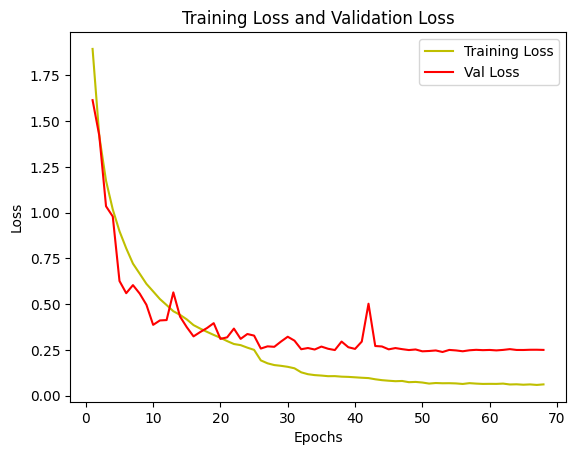

In [16]:
# plot the loss curve
loss_curve = history.history["loss"]
val_loss_curve = history.history["val_loss"]
epochs = range(1, len(loss_curve) + 1)
plt.plot(epochs, loss_curve, 'y', label="Training Loss")
plt.plot(epochs, val_loss_curve, 'r', label="Val Loss")
plt.title("Training Loss and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

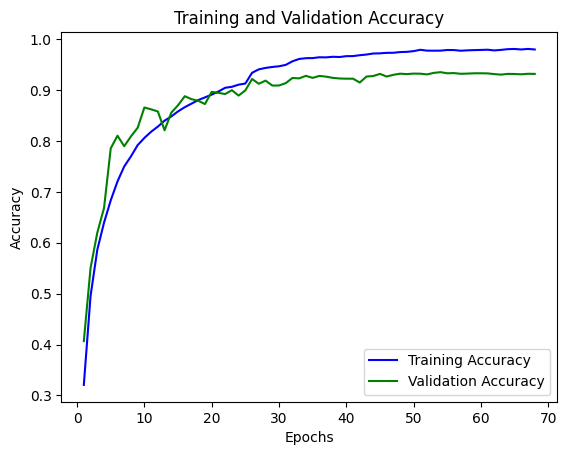

In [17]:
# plot the accuracy curve
acc_curve = history.history["accuracy"]
val_acc_curve = history.history["val_accuracy"]
epochs = range(1, len(acc_curve) + 1)
plt.plot(epochs, acc_curve, 'b', label="Training Accuracy")
plt.plot(epochs, val_acc_curve, 'g', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [27]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [28]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_ds)
y_pred_classes = [np.argmax(element) for element in y_pred]

print(classification_report(y_test, y_pred_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1000
           1       0.97      0.97      0.97      1000
           2       0.92      0.90      0.91      1000
           3       0.87      0.82      0.85      1000
           4       0.93      0.94      0.93      1000
           5       0.87      0.87      0.87      1000
           6       0.93      0.96      0.95      1000
           7       0.95      0.96      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



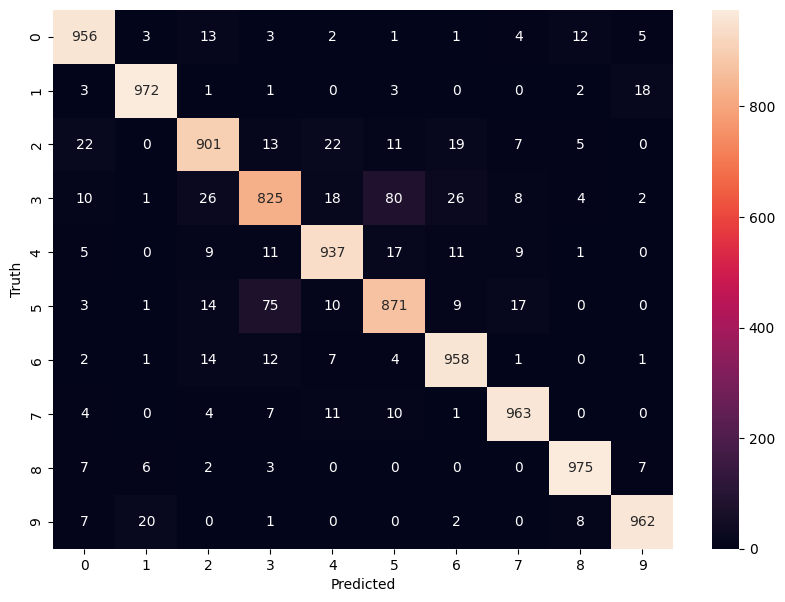

In [29]:
cm = tf.math.confusion_matrix(y_test, np.argmax(y_pred, axis=1))

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Final Report

#### ResNet Implementation Results

The implemented ResNet architecture demonstrated remarkable performance on the CIFAR-10 dataset. With approximately 21.2 million parameters, the model achieved exceptional training accuracy of 99.93% and test accuracy of 93.19%.

| Model | Training Accuracy (%) | Test Accuracy (%) | Parameters (M) | Epochs | Training-Test Gap (%) |
|-------|----------------------|-------------------|----------------|---------|---------------------|
| **ResNet** | **99.93** | **93.19** | **21.2** | **53\*** | **6.74** |
| Inception + BatchNorm | 99.31 | 89.87 | 1.6 | 50 | 9.44 |
| VGG + BatchNorm | 95.29 | 86.58 | 33.6 | 50 | 8.71 |
| AlexNet | 81.97 | 77.53 | 3.2 | 50 | 4.44 |

*Note: ResNet was initially configured for 150 epochs but stopped at 68, with best performance at epoch 53.

#### Key Findings

- The ResNet implementation achieved the highest test accuracy (93.19%) among all models, demonstrating superior generalization capabilities despite having a moderate parameter count.
- While both ResNet and Inception models reached very high training accuracy (>99%), ResNet showed better generalization with a smaller gap between training and test accuracy.
- The Inception model stands out for its efficiency, achieving strong performance (89.87% test accuracy) with only 1.6M parameters, significantly fewer than other architectures.
- AlexNet, while having the smallest gap between training and test accuracy, showed limited overall performance, suggesting underfitting rather than optimal generalization.

#### Future Work

- Additional regularization techniques can be considered in the ResNet model to further reduce the training-test accuracy gap while maintaining high performance.
- Explore potential hybrid architectures that combine ResNet's strong performance with Inception's parameter efficiency.
- For low-end applications, the Inception model might be the most practical choice, offering a strong balance between model size and performance.